<a href="https://colab.research.google.com/github/aguilarafa2010/PLN/blob/main/Trabalho_Final_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# Bibliotecas

import pandas as pd
import numpy as np

import nltk
from nltk import tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

plt.rcParams["figure.figsize"] = [15,10]
sns.set_style("darkgrid")


!conda install -c conda-forge spacy
!python -m spacy download pt_core_news_sm

import pt_core_news_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/bin/bash: conda: command not found
     |████████████████████████████████| 21.2 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [2]:
# Leitura do arquivo
f = open("/content/sample_data/2000_Textos_Novo.txt","r")

#1) Criar um corpus com as instâncias de 2000_textos.txt, seguindo a seguinte estratégia:
O novo corpus terá instâncias rotuladas com uma das 3 classes
possíveis:
- classe “positivo”: instâncias da base original rotuladas como “alegria”;
- classe “negativo”: instâncias rotuladas como “raiva”, “medo”,
“desgosto” e “tristeza”;
- classe “neutro”: instâncias da base original rotuladas como “neutro”.
As instâncias rotuladas como “surpresa” não serão utilizadas neste
novo corpus. 

In [3]:
# Métodos e funções

def mudaClasse(x):
  if 'alegria' in x[1]:
    x[1] = 'positivo'
  elif 'neutro' in x[1]:
    x[1] = 'neutro'
  elif 'surpresa' in x[1]:
    x[1] = 'surpresa'
  elif 'raiva' in x[1] or 'tristeza' in x[1] or 'medo' in x[1] or 'desgosto' in x[1]:
    x[1] = 'negativo'

  return x

In [4]:
arquivo = []
for i in f:
  aux = i.split(';')
  arquivo.append([aux[2],aux[0]])

arquivo = [mudaClasse(x) for x in arquivo]

df = pd.DataFrame(arquivo)
df.columns = ['Texto', 'Classe']
df

,Texto,Classe
0,"irã liberta viúva condenada ao apedrejamento, ...",positivo
1,haiti sofre com cólera depois da passagem do f...,negativo
2,mulher acorda e encontra crocodilo de 3 m e 27...,surpresa
3,enchentes causam a morte de 4 pessoas em al: v...,negativo
4,"sem detalhes do que será discutido, revisão do...",neutro
...,...,...
1994,crise econômica agrava situação dos direitos h...,negativo
1995,reforma tributária ‘é o frankenstein do franke...,negativo
1996,"pernambuco tem apenas 2,5% da área original de...",negativo
1997,veja as principais notícias de abril: oms elev...,negativo


In [5]:
df = df.drop(df[df.Classe == 'surpresa'].index)

classes = df['Classe']
classes.unique()

array(['positivo', 'negativo', 'neutro'], dtype=object)

#2) Plote a nova distribuição das classes.

In [6]:
grupos = df.groupby('Classe')
grupos.describe()

Texto                                                               
         count unique                                                top freq
Classe                                                                       
negativo  1021   1021  familiares de tripulação do voo mh370 criticam...    1
neutro     542    542  definição sobre candidatura de ciro ao governo...    1
positivo   184    184  leão resgatado de circo em ms ganha nova casa:...    1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


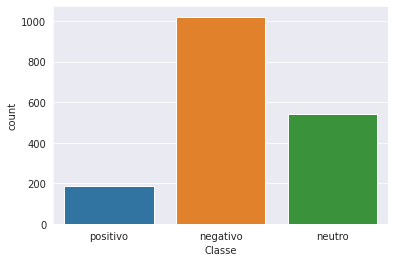

In [7]:
sns.countplot(df.Classe)

#3) Treine ao menos 3 classificadores que você achar mais apropriado para o problema:

Utilize a validação cruzada com 10-folds.

In [8]:
# Tokenização das palavras

contador = []

stop_words = set(stopwords.words('portuguese'))
nlp = pt_core_news_sm.load()
for index, row in df.iterrows():
  palavras = tokenize.word_tokenize(row.Texto, language='portuguese')
  palavras_tokenize = [word.lower() for word in palavras if word.isalpha() and word not in stop_words]

  texto = " ".join(palavras_tokenize)  
  doc = nlp(texto)

  aux = ""

  for token in doc:
    aux += f" {token.lemma_}"

  df.at[index, 'Texto_Atualizado'] = aux

  contador.append(Counter(palavras))

df.head()

,Texto,Classe,Texto_Atualizado
0,"irã liberta viúva condenada ao apedrejamento, ...",positivo,irã liberto viúvo condenar apedrejamento dize...
1,haiti sofre com cólera depois da passagem do f...,negativo,haiti sofrer cólera passagem furacão sandy ap...
3,enchentes causam a morte de 4 pessoas em al: v...,negativo,enchente causar morte pessoa al vítima mãe fi...
4,"sem detalhes do que será discutido, revisão do...",neutro,detalhe discutir revisão planar diretor comed...
5,chávez apresenta neto de allende como companhe...,neutro,chávez apresentar neto allende companheiro fi...


In [9]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df.Texto_Atualizado)
vectors.shape

(1747, 6248)

In [10]:
# Prepara as classes

def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

In [58]:
# Separando os dados em Treinamento e Teste

X_train, X_test, y_train, y_test = train_test_split(vectors, df.Classe, 
                                                    test_size=0.1, random_state=1)

y_train, y_test = prepare_targets(y_train, y_test)

In [12]:
# TREINANDO MODELO SVM
# Prepara os dados de saída

# Create the LinearSVC model
clf_a = LinearSVC(random_state=1, dual=False)
# Fit the model
clf_a.fit(X_train, y_train)

print(f'Model test accuracy: {clf_a.score(X_test, y_test)*100:.3f}%')

# Avaliando o modelo
yhat_a = clf_a.predict(X_test)

Model test accuracy: 74.857%


In [49]:
from sklearn import tree
# MODELO LOGISTIC REGRESSION

# declara o classificador
clf_b = LogisticRegression()

# treina o classificador
clf_b = clf_b.fit(X_train, y_train)

# testa usando a base de testes
yhat_b = clf_b.predict(X_test)

print(f'Model test accuracy: {clf_b.score(X_test, y_test)*100:.3f}%')

Model test accuracy: 75.429%


In [14]:
# MODELO NAIVE BAYES

# Treina o classificador
clf_c = GaussianNB()
clf_c = clf_c.fit(X_train.toarray(), y_train)

# calcula a acurácia na base de teste
score=clf_c.score(X_test.toarray(), y_test)

# testa usando a base de testes
yhat_c = clf_c.predict(X_test.toarray())

print(f'Model test accuracy: {clf_c.score(X_test.toarray(), y_test)*100:.3f}%')

Model test accuracy: 72.000%


# 4) Gere a matriz de confusão e calcule: cobertura, precisão e medida-f.

In [40]:
recall_a = recall_score(y_test, yhat_a, average='weighted')
recall_b = recall_score(y_test, yhat_b, average='weighted')
recall_c = recall_score(y_test, yhat_c, average='weighted')

print('Recall: %.3f' % recall_a)
print('Recall: %.3f' % recall_b)
print('Recall: %.3f' % recall_c)

Recall: 0.749
Recall: 0.594
Recall: 0.720


In [16]:
precision_a = precision_score(y_test, yhat_a, average='weighted')
precision_b = precision_score(y_test, yhat_b, average='weighted')
precision_c = precision_score(y_test, yhat_c, average='weighted')

print('Precision: %.3f' % precision_a)
print('Precision: %.3f' % precision_b)
print('Precision: %.3f' % precision_c)



Precision: 0.734
Precision: 0.656
Precision: 0.702


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
#https://www.baeldung.com/cs/multi-class-f1-score
score_a = f1_score(y_test, yhat_a, average='weighted')
score_b = f1_score(y_test, yhat_b, average='weighted')
score_c = f1_score(y_test, yhat_c, average='weighted')

print('F-Measure: %.3f' % score_a)
print('F-Measure: %.3f' % score_b)
print('F-Measure: %.3f' % score_c)

F-Measure: 0.735
F-Measure: 0.442
F-Measure: 0.704


#5) Plote a matriz de confusão e imprima a cobertura, precisão e medida-f para cada classe.

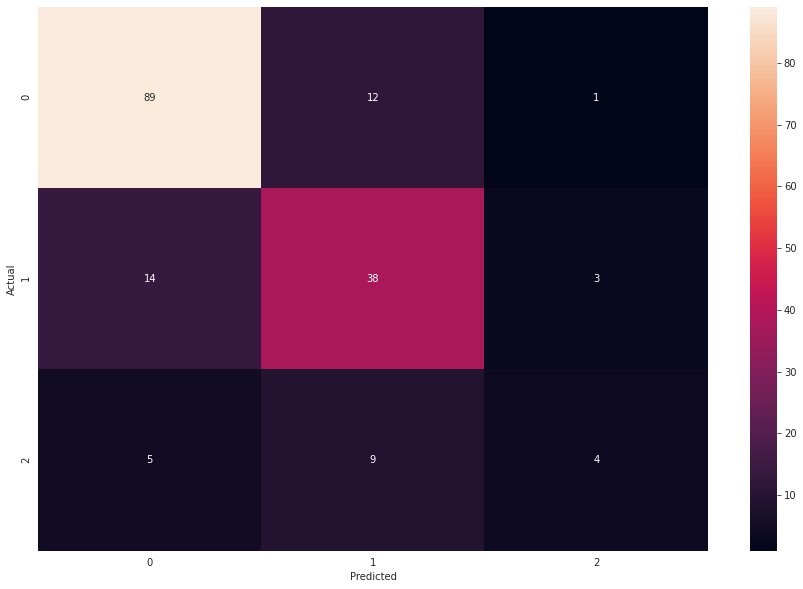

In [51]:
confusion_matrix = pd.crosstab(y_test, yhat_a, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True )

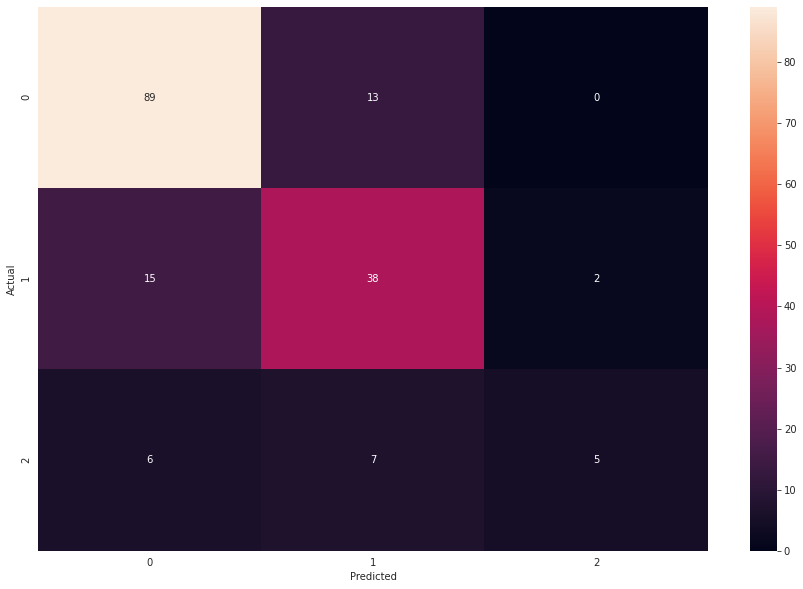

In [50]:
confusion_matrix = pd.crosstab(y_test, yhat_b, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True )

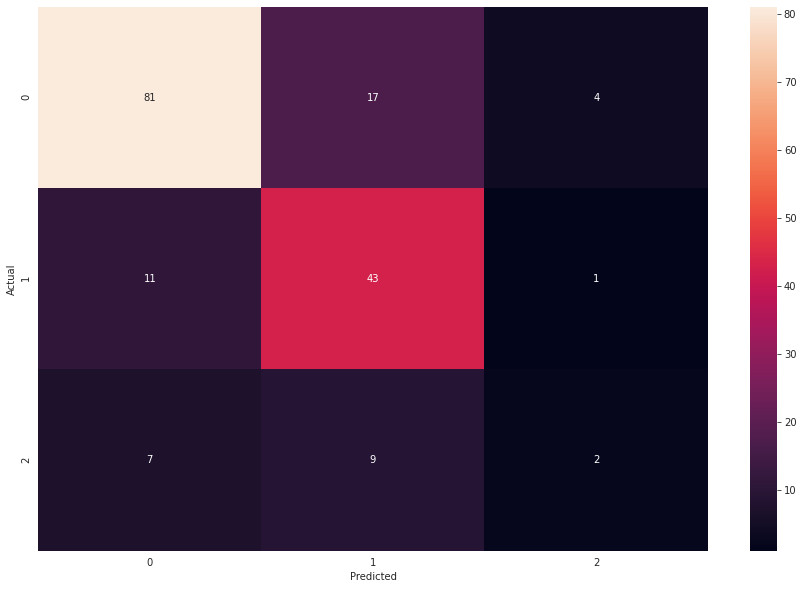

In [59]:
confusion_matrix = pd.crosstab(y_test, yhat_c, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True )

In [22]:
recall = recall_score(y_test, yhat_a, average=None)
recall

array([0.87254902, 0.69090909, 0.22222222])

In [23]:
recall = recall_score(y_test, yhat_b, average=None)
recall

array([1.        , 0.01818182, 0.        ])

In [25]:
recall = recall_score(y_test, yhat_c, average=None)
recall

array([0.79411765, 0.78181818, 0.11111111])

In [26]:
precision = precision_score(y_test, yhat_a, average=None)
precision

array([0.82407407, 0.6440678 , 0.5       ])

In [27]:
precision = precision_score(y_test, yhat_b, average=None)
precision

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.5862069, 1.       , 0.       ])

In [28]:
precision = precision_score(y_test, yhat_c, average=None)
precision

array([0.81818182, 0.62318841, 0.28571429])

In [29]:
score = f1_score(y_test, yhat_a, average=None)
score

array([0.84761905, 0.66666667, 0.30769231])

In [30]:
score = f1_score(y_test, yhat_b, average=None)
score

array([0.73913043, 0.03571429, 0.        ])

In [31]:
score = f1_score(y_test, yhat_c, average=None)
score

array([0.80597015, 0.69354839, 0.16      ])